Combined signal mean: 1.2405743066736605
Freq range: 0.0 to 498.0


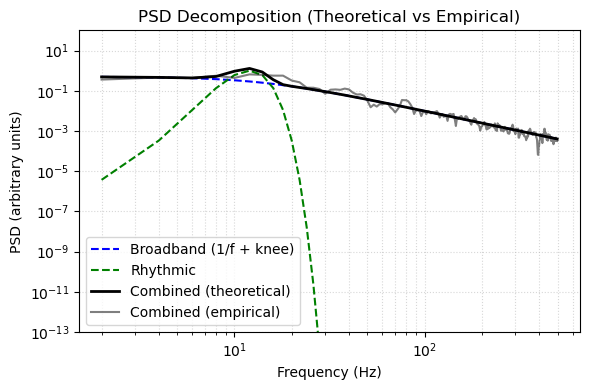

In [55]:
# Simulate data

from spectral_decomposition import spectrum

res = spectrum(
    sampling_rate=1000,
    duration=0.5,
    aperiodic_exponent=2.0,
    aperiodic_offset=2.0,
    knee=200,
    peaks=[{'freq':12, 'amplitude': 1.0, 'sigma': 2.0}],
    average_firing_rate=0.0,
    random_state=42,
    direct_estimate=True,
    plot=True
)

# Access time-domain signals
td = res.time_domain
print("Combined signal mean:", td.combined_signal.mean())

# Access freq-domain data
fd = res.frequency_domain
print("Freq range:", fd.frequencies[0], "to", fd.frequencies[-1])

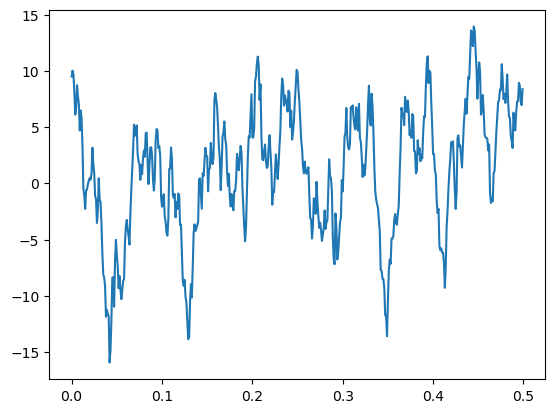

In [56]:
# This is what the signal looks like!

import matplotlib.pyplot as plt

signal = td.combined_signal
time = td.time

plt.plot(time, signal)
plt.show()

In [57]:
# Single taper

from scipy.signal import welch

def single_taper_psd(signal, window, fs=1000, window_length=None, overlap=0):
    N = len(signal)
    nperseg = N if window_length is None else int(window_length * fs) # number of samples per segment
    noverlap = int(nperseg * overlap) # number of samples per overlap

    freqs, psd = welch(signal,
                       fs=fs,
                       window=window,
                       nperseg=nperseg,
                       noverlap=noverlap,
                       scaling='density' # return psd
                       )

    return freqs, psd

In [58]:
# Multitaper (not yet scaled)
import numpy as np
from scipy.signal.windows import dpss
from scipy.fft import fft, fftfreq

def multitaper_psd(signal, fs=1000, TW=1, K=None):
    N = len(signal)  

    # deafult to 2*NW - 1 tapers
    K = K or int(2 * TW - 1)

    # create dpss tapers
    tapers = dpss(N, TW, K)  # shape: (K, N)

    # Apply each taper to the signals
    tapered_signals = np.array([signal * taper for taper in tapers])  # shape: (K, N)

    fft_sum = np.sum(np.abs(fft(tapered_signals, axis=1))**2, axis=0) / (fs * N)  # summed PSD across tapers
    fft_sum = fft_sum * fs / 2 # scaling

    psd = fft_sum / K  # Average PSD
    freqs = fftfreq(N, d=1/fs)

    return freqs[freqs >= 0], psd[freqs >= 0] # only want positive frequencies

In [59]:
# Normalization

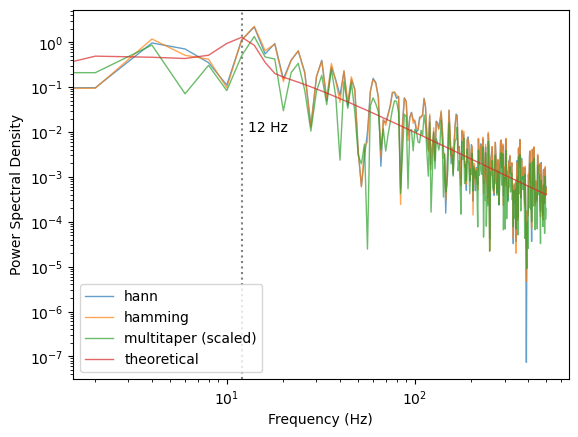

In [60]:
# Plotting...

freq_hann, psd_hann = single_taper_psd(signal, 'hann')
freq_hamming, psd_hamming = single_taper_psd(signal, 'hamming')
freq_mt, psd_mt = multitaper_psd(signal)

plt.loglog(freq_hann, psd_hann, linewidth=1, alpha=0.7, label='hann')
plt.loglog(freq_hamming, psd_hamming, linewidth=1, alpha=0.7, label='hamming')
plt.loglog(freq_mt, psd_mt, linewidth=1, alpha=0.7, label='multitaper (scaled)')
plt.plot(fd.frequencies, fd.combined_spectrum, linewidth=1, alpha=0.7, label='theoretical')

plt.axvline(x=12, color='gray', linestyle=':', linewidth=1.5)
plt.text(13, 0.01,'12 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()

In [84]:
# Calculate Bias

def calc_mean_bias(empiricalPSD, theoreticalPSD):
    N = len(theoreticalPSD)
    empiricalPSD = empiricalPSD[:-1] if (len(empiricalPSD) > N) else empiricalPSD
    biases = empiricalPSD - theoreticalPSD # do we need to change this cuz the empirical length is 251 while theoretical length is 250
    meanBias = np.sum(biases)/N

    return meanBias

In [62]:
# Calculate Variance

In [63]:
# Calculate Spectral Leakage

In [ ]:
# Taper Comparison

#print(freq_hann)
#print(fd.frequencies)

hannBias = calc_mean_bias(psd_hann, fd.combined_spectrum)
hammingBias = calc_mean_bias(psd_hamming, fd.combined_spectrum)
mtBias = calc_mean_bias(psd_mt, fd.combined_spectrum)
print(f"Hann Bias: {hannBias}")
print(f"Hamming Bias: {hammingBias}")
print(f"Multitaper Bias: {mtBias}")

[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198. 200. 202. 204. 206. 208. 210. 212. 214. 216. 218. 220. 222.
 224. 226. 228. 230. 232. 234. 236. 238. 240. 242. 244. 246. 248. 250.
 252. 254. 256. 258. 260. 262. 264. 266. 268. 270. 272. 274. 276. 278.
 280. 282. 284. 286. 288. 290. 292. 294. 296. 298. 300. 302. 304. 306.
 308. 310. 312. 314. 316. 318. 320. 322. 324. 326. 328. 330. 332. 334.
 336. 338. 340. 342. 344. 346. 348. 350. 352. 354. 356. 358. 360. 362.
 364. 366. 368. 370. 372. 374. 376. 378. 380. 382. 384. 386. 388. 390.
 392. 